In [1]:
import numpy as np
import json

import duckdb # conda install -c conda-forge python-duckdb
#import yaml # conda install -c conda-forge pyyaml
#import dbt # conda install -c conda-forge dbt
#import jinja2 # conda install -c anaconda jinja2

#import sqlite3
import os
import pandas as pd

path_folder = os.getcwd()

In [2]:
path_file_zipcode_coordinates = os.path.join(path_folder,"data","raw","zipcode_coordinates.csv")
path_file_oa_offers = os.path.join(path_folder,"data","raw","offer_acceptance_offers.csv")
path_file_oa_orders = os.path.join(path_folder,"data","raw","offer_acceptance_orders.csv")

In [3]:
zipcode_coordinates = pd.read_csv(path_file_zipcode_coordinates)
oa_offers = pd.read_csv(path_file_oa_offers)
oa_orders = pd.read_csv(path_file_oa_orders)

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (9,10,11,12,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
file_name_database = "data.db"
#path_file_database = os.path.join(path_folder_data, file_name_database)
path_file_database = "flock.db"
#db_conn = sqlite3.connect(path_file_sql_generated_database)
db_conn = duckdb.connect(path_file_database)

cursor = db_conn.cursor()

In [5]:
sql = """
DROP TABLE IF EXISTS offer_acceptance_orders;
CREATE TABLE IF NOT EXISTS offer_acceptance_orders AS
SELECT * FROM read_csv_auto('data/raw/offer_acceptance_orders.csv');

DROP TABLE IF EXISTS offer_acceptance_offers;
CREATE TABLE IF NOT EXISTS offer_acceptance_offers AS
SELECT * FROM read_csv_auto('data/raw/offer_acceptance_offers.csv');

DROP TABLE IF EXISTS zipcode_coordinates;
CREATE TABLE IF NOT EXISTS zipcode_coordinates AS
SELECT * FROM read_csv_auto('data/raw/zipcode_coordinates.csv');
"""
cursor.sql(sql)
db_conn.commit()

In [6]:
# where save?
# where this file go write/read? ETL or dataclean? how differentiate between raw, temp, and out?
# dbt?
# jinja for files?
# 

In [7]:
sql = """
DROP TABLE IF EXISTS oa_orders_temp;

CREATE TABLE IF NOT EXISTS oa_orders_temp AS

-- add a new version of the reference number column cleaned as a list of string references to the orders table
WITH 
orders_references AS
(
SELECT ORD0.*,
regexp_split_to_array(
replace(
replace(
replace(
replace(
replace(
ORD0.REFERENCE_NUMBER
, '\n', '')
, '"', '')
, ' ', '')
, '[', '')
, ']', '')
, 
',') 
as REFERENCE_NUMBERS,
FROM 
offer_acceptance_orders ORD0
),



-- optional filtering of just FTLs (must also drop transport mode)
orders_transport AS 
(
SELECT ORD0.*
-- {% if filtering_ftl == 1 %}
-- EXCEPT (SELECT ORD1.TRANSPORT_MODE FROM orders_references ORD1)
-- {% endif %}
FROM 
orders_references ORD0
-- {% if filtering_ftl == 1 %}
-- WHERE ORD0.TRANSPORT_MODE = 'FTL'
-- {% endif %}
),



-- add the x/y coordinate columns of the orders' origin and destination zipcodes to orders table
-- also shrinks the x/y coordinate columns by a factor of 1 million
orders_zipcoord AS
(
SELECT ORD0.*, 
ZIP_ORIG.X_COORD/1000000 as X_COORD_ORIG,
ZIP_ORIG.Y_COORD/1000000 as Y_COORD_ORIG,
ZIP_DEST.X_COORD/1000000 as X_COORD_DEST,
ZIP_DEST.Y_COORD/1000000 as Y_COORD_DEST
FROM 
orders_transport ORD0
LEFT OUTER JOIN
zipcode_coordinates ZIP_ORIG
ON ORD0.ORIGIN_3DIGIT_ZIP = ZIP_ORIG."3DIGIT_ZIP"
LEFT OUTER JOIN 
zipcode_coordinates ZIP_DEST
ON ORD0.DESTINATION_3DIGIT_ZIP = ZIP_DEST."3DIGIT_ZIP"
),



-- crops the zipcode nodes of orders table to be only within the mainland US    
orders_zipcoords_mainland_us AS
(
SELECT ORD0.*
FROM 
orders_zipcoord ORD0
WHERE
ORD0.X_COORD_ORIG >= -15 AND ORD0.X_COORD_ORIG <=  -7 AND
ORD0.Y_COORD_ORIG >= 2.5 AND ORD0.Y_COORD_ORIG <= 6.5 AND
ORD0.X_COORD_DEST >= -15 AND ORD0.X_COORD_DEST <=  -7 AND
ORD0.Y_COORD_DEST >= 2.5 AND ORD0.Y_COORD_DEST <= 6.5
),



-- add euclidean distance column of shipping routes to orders table
orders_distance AS
(
SELECT 
ORD0.*,
(POWER((ORD0.X_COORD_DEST-ORD0.X_COORD_ORIG),2) + POWER((ORD0.Y_COORD_DEST-ORD0.Y_COORD_ORIG),2)) AS DISTANCE
FROM orders_zipcoords_mainland_us ORD0
),



-- add columns of the month, weekday, and hour of an order's date of posting and deadline to the orders table
orders_time_categ AS
(
SELECT ORD0.*,
extract("month" FROM ORD0.ORDER_DATETIME_PST) AS ORDER_MONTH,
dayname(ORD0.ORDER_DATETIME_PST) AS ORDER_DAY,
extract("hour" FROM ORD0.ORDER_DATETIME_PST) AS ORDER_HOUR,
extract("month" FROM ORD0.PICKUP_DEADLINE_PST) AS DEADLINE_MONTH,
dayname(ORD0.PICKUP_DEADLINE_PST) AS DEADLINE_DAY,
extract("hour" FROM ORD0.PICKUP_DEADLINE_PST) AS DEADLINE_HOUR,
FROM orders_distance ORD0
),



-- add column on time between order's posting and its deadline to orders table
-- also performs data integrity check that returns null if the duration is "impossible" (i.e. <= 0)
orders_duration AS 
(
SELECT ORD1.*,
(
CASE 
WHEN 
(
((least(ORD1.ORDER_DATETIME_PST, ORD1.PICKUP_DEADLINE_PST) = ORD1.ORDER_DATETIME_PST) 
AND
(ORD1.ORDER_DATETIME_PST != ORD1.PICKUP_DEADLINE_PST)) 
)
THEN
date_diff(ORD1.TEMP_TIME_UNIT_SECOND, ORD1.ORDER_DATETIME_PST, ORD1.PICKUP_DEADLINE_PST)
ELSE
NULL
END
)
AS TIME_BETWEEN_ORDER_AND_DEADLINE
FROM 
(SELECT ORD0.*, 
'second' as TEMP_TIME_UNIT_SECOND
FROM orders_time_categ ORD0) ORD1
),



-- adds a column of distance over duration (with a small positive number .0001 added to prevent zero division) to orders table
orders_speed AS
(
SELECT 
ORD0.*,
((ORD0.DISTANCE) / (ORD0.TIME_BETWEEN_ORDER_AND_DEADLINE) + 0.0001) as DISTANCE_OVER_ORDER_TIME
FROM
orders_duration ORD0
),



-- adds the delivery route geodata columns to orders table
orders_delivery_data AS
(
SELECT *
FROM
orders_speed ORD0
-- LEFT OUTER JOIN (SELECT * FROM delivery_route_geodata DRGD0) ON DRGD0.REFERENCE_NUMBER1 = ORD0.REFERENCE_NUMBER1
),



-- this unnests the list-converted reference numbers column, expanding the row count and changing the row schema
orders_unnested AS
(
SELECT 
ORD0.*, 
-- dbt jinja if-statement: if explode_references was set to 1, unnest the reference numbers, else reuse the pre-list-converted
-- {% if explode_references == 1 %}
UNNEST(ORD0.REFERENCE_NUMBERS) AS REFERENCE_NUMBERS1 
-- {% else %}
-- ORD0.REFERENCE_NUMBER AS REFERENCE_NUMBERS1
-- {% endif %}
FROM orders_delivery_data ORD0
)



SELECT ORD0.* 
FROM orders_unnested ORD0

;
"""
cursor.sql(sql)
sql_create_offer_acceptance_orders_temp = sql
db_conn.commit()

In [8]:
sql = """
DROP TABLE IF EXISTS oa_offers_temp;
CREATE TABLE IF NOT EXISTS oa_offers_temp AS

-- applies a data integrity check that removes rows that aren't valid. 
-- Specifically, rows where offer type is quote should have a reference number column with only one reference 
-- and rows where offer type is pool should have many references.
-- This is a row-decreasing operation
WITH 
offer_acceptance_offers_correct AS (
SELECT OFF0.*
FROM offer_acceptance_offers OFF0
WHERE 
(OFF0.OFFER_TYPE = 'quote') AND (len(regexp_split_to_array(OFF0.REFERENCE_NUMBER, ',')) = 1) 
OR
(OFF0.OFFER_TYPE = 'pool') AND (len(regexp_split_to_array(OFF0.REFERENCE_NUMBER, ',')) >= 1)
),

-- add a new version of the reference number column cleaned as a list of string references to the offers table
offer_references AS (
SELECT
OFF0.*,
regexp_split_to_array(
replace(
replace(
replace(
replace(
replace(
OFF0.REFERENCE_NUMBER
, '\n', '')
, '"', '')
, ' ', '')
, '[', '')
, ']', '')
, 
',') 
as REFERENCE_NUMBERS,
FROM offer_acceptance_offers_correct OFF0
),

-- this unnests the list-converted reference numbers column, expanding the row count and changing the row schema
offers_unnested AS
(
SELECT 
OFF0.*,
-- dbt jinja if-statement: if explode_references was set to 1, unnest the reference numbers, else reuse the pre-list-converted
-- {% if explode_references == 1 %}
unnest(OFF0.REFERENCE_NUMBERS) AS REFERENCE_NUMBERS1
-- {% else %}
-- OFF0.REFERENCE_NUMBER AS REFERENCE_NUMBERS1
-- {% endif %}
FROM offer_references OFF0
)

SELECT
OFF0.*
FROM offers_unnested OFF0
;
"""
cursor.sql(sql)
sql_create_offer_acceptance_offers_temp = sql
db_conn.commit()

# support for joining not on nested
# support for ftl
# nulls
# data cleans

In [47]:
sql = """

DROP TABLE IF EXISTS temp_oa_joined_cleaned;
CREATE TABLE IF NOT EXISTS temp_oa_joined_cleaned AS
WITH
temp_oa_joined AS
(
SELECT
ORD0.REFERENCE_NUMBERS1,
-- {% if filtering_ftl != 1 %}
ORD0.TRANSPORT_MODE,
-- {% endif %}
ORD0.ORIGIN_3DIGIT_ZIP,
ORD0.DESTINATION_3DIGIT_ZIP,
ORD0.X_COORD_ORIG, ORD0.X_COORD_DEST, ORD0.Y_COORD_ORIG, ORD0.Y_COORD_DEST,
ORD0.TEMP_TIME_UNIT_SECOND, 
ORD0.ORDER_DATETIME_PST,
ORD0.TIME_BETWEEN_ORDER_AND_DEADLINE,
OFF0.CREATED_ON_HQ,
OFF0.LOAD_DELIVERED_FROM_OFFER,
OFF0.RATE_USD,
OFF0.OFFER_TYPE
FROM 
oa_orders_temp ORD0
LEFT OUTER JOIN
oa_offers_temp OFF0
ON
ORD0.REFERENCE_NUMBERS1 = OFF0.REFERENCE_NUMBERS1
),

-- cleans the joined table. Specifically, all rows where Transport mode = FTL should only correspond with 
-- offers with 1 order and offers of the type quote
-- if FTL's were filtered beforehand, that means just filter for quote = 1.
temp_oa_joined_cleaned AS
(
SELECT
OA0.*
FROM
temp_oa_joined OA0
-- {% if filtering_ftl == 1 %}
EXCEPT (SELECT OA1.* FROM temp_oa_joined OA1 WHERE OA1.TRANSPORT_MODE = 'FTL' AND OA1.OFFER_TYPE != 'quote')
-- {% else %}
-- WHERE OA0.OFFER_TYPE != 'quote' -- assumes transport_mode column isn't present and all of order's rows are FTL anyways
-- {% endif %}
)

SELECT * FROM temp_oa_joined_cleaned;
"""
cursor.sql(sql)
db_conn.commit()

In [48]:
sql = """
DROP TABLE IF EXISTS oa;
CREATE TABLE IF NOT EXISTS oa AS
-- add leadtime column with integrity checks
WITH orders_lead_time AS
(
SELECT 
OA1.REFERENCE_NUMBERS1,
OA1.LEAD_TIME
FROM 
(SELECT
OA0.REFERENCE_NUMBERS1,
(
CASE 
WHEN
(least(OA0.ORDER_DATETIME_PST,OA0.CREATED_ON_HQ) = OA0.ORDER_DATETIME_PST)
THEN
(CAST(date_diff(OA0.TEMP_TIME_UNIT_SECOND, OA0.ORDER_DATETIME_PST,OA0.CREATED_ON_HQ) AS DECIMAL)/(OA0.TIME_BETWEEN_ORDER_AND_DEADLINE + 0.0001))
ELSE
NULL
END
)
AS LEAD_TIME
FROM
temp_oa_joined_cleaned OA0
WHERE OA0.LOAD_DELIVERED_FROM_OFFER = true
) OA1
WHERE 
(OA1.LEAD_TIME IS NOT NULL)
OR (OA1.LEAD_TIME = 0.0)
),


offers_aggregated AS
(
SELECT
OA0.REFERENCE_NUMBERS1,
STDDEV_POP(OA0.RATE_USD) AS SD_LOG_RATE_USD,
AVG(LN(OA0.RATE_USD+1)) AS LOG_RATE_USD,
COUNT(*) AS ORDER_OFFER_AMOUNT
FROM
temp_oa_joined_cleaned OA0
GROUP BY OA0.REFERENCE_NUMBERS1
),

oa as (
SELECT
ORD0.*,
OFF_A0.LOG_RATE_USD, OFF_A0.SD_LOG_RATE_USD, OFF_A0.ORDER_OFFER_AMOUNT,
ORD_LT0.LEAD_TIME
FROM oa_orders_temp ORD0
LEFT OUTER JOIN offers_aggregated OFF_A0 
ON ORD0.REFERENCE_NUMBERS1 = OFF_A0.REFERENCE_NUMBERS1
LEFT OUTER JOIN orders_lead_time ORD_LT0 
ON ORD0.REFERENCE_NUMBERS1 = ORD_LT0.REFERENCE_NUMBERS1
)

SELECT OA0.*
FROM
oa OA0
;
"""
cursor.sql(sql)
db_conn.commit()

In [49]:

columns_result = cursor.sql("SELECT COLUMN_NAME FROM Information_schema.columns where Table_name like 'oa'")
columns = pd.DataFrame(columns_result.fetchall())
df_result = cursor.sql("SELECT * FROM oa")
df = pd.DataFrame(df_result.fetchall())
df.columns = columns.iloc[:,0].values.tolist()
oa = df

In [213]:
sql = """
DROP TABLE IF EXISTS zipcode_groupby;
CREATE TABLE IF NOT EXISTS zipcode_groupby AS
WITH temp_oa_joined_cleaned1 AS 
(
SELECT * FROM temp_oa_joined_cleaned
--WHERE RATE_USD IS NOT NULL
),


zipcode_groupby AS
(
SELECT Z3.ZIP, 
LN(COUNT(*)+1)/10 AS ZIP_OFFER_NUM_LVL,  
COUNT(*) AS ZIP_OFFER_NUM, 
AVG(LN(Z3.RATE_USD+1)) ZIP_RATE_AVG
FROM
(
SELECT 
OA0.ORIGIN_3DIGIT_ZIP AS ZIP, OA0.RATE_USD
FROM temp_oa_joined_cleaned1 OA0
UNION ALL
SELECT 
OA1.DESTINATION_3DIGIT_ZIP AS ZIP,  OA1.RATE_USD
FROM temp_oa_joined_cleaned1 OA1
) AS Z3
GROUP BY Z3.ZIP
),

unique_zipcoords AS
(
SELECT OA0.ORIGIN_3DIGIT_ZIP AS ZIP, OA0.X_COORD_ORIG AS X_COORD, OA0.Y_COORD_ORIG AS Y_COORD
FROM temp_oa_joined_cleaned1 OA0
UNION
SELECT OA1.DESTINATION_3DIGIT_ZIP AS ZIP, OA1.X_COORD_DEST AS X_COORD, OA1.Y_COORD_DEST AS Y_COORD
FROM temp_oa_joined_cleaned1 OA1
)

SELECT 
UZC0.ZIP, UZC0.X_COORD, UZC0.Y_COORD, 
ZCGB0.ZIP_OFFER_NUM, 
ZCGB0.ZIP_OFFER_NUM_LVL,
ZCGB0.ZIP_RATE_AVG,
NTILE(3)
OVER (ORDER BY ZCGB0.ZIP_RATE_AVG DESC) AS ZIP_RATE_AVG_LVL,
FROM
unique_zipcoords UZC0
INNER JOIN
zipcode_groupby ZCGB0
ON UZC0.ZIP = ZCGB0.ZIP
;
"""
cursor.sql(sql)
db_conn.commit()

columns_result = cursor.sql("SELECT COLUMN_NAME FROM Information_schema.columns where Table_name like 'zipcode_groupby'")
columns = pd.DataFrame(columns_result.fetchall())

df_result = cursor.sql("SELECT * FROM zipcode_groupby")
df = pd.DataFrame(df_result.fetchall())
df.columns = columns.iloc[:,0].values.tolist()
zipcode_groupby = df

In [214]:
#plt.hist(zipcode_groupby["ZIP_RATE_AVG"])

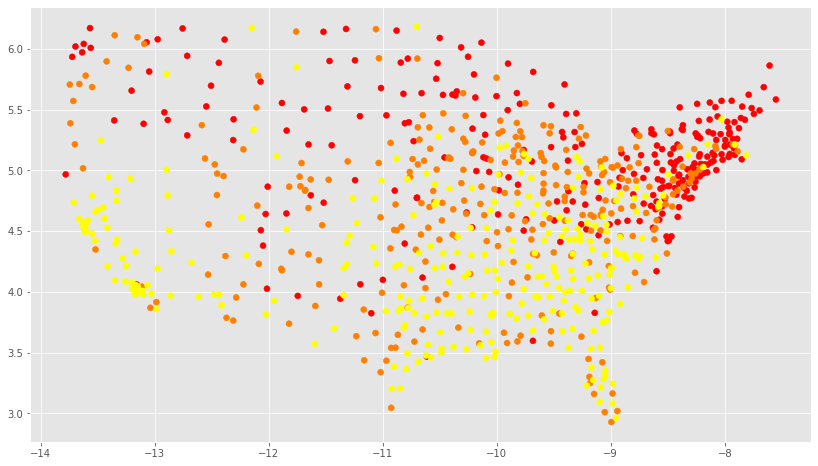

In [215]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(14,8))

from sklearn.cluster import KMeans
np.random.seed(5)
kmeans = KMeans(20)
kmeans.fit(zipcode_groupby[["X_COORD","Y_COORD","ZIP_OFFER_NUM_LVL"]])


colors = zipcode_groupby["ZIP_OFFER_NUM"]; cmap = "autumn"
colors = zipcode_groupby["ZIP_RATE_AVG_LVL"]; cmap = "autumn"
#colors = kmeans.labels_; cmap = "tab20"

ax.scatter(
zipcode_groupby["X_COORD"],
zipcode_groupby["Y_COORD"],
c=colors,
cmap=cmap
)


In [216]:
zipcode_groupby["GROUP"] = kmeans.labels_

In [217]:
from pyproj import Proj, transform

inProj = Proj(init='epsg:3857')
outProj = Proj(init='epsg:4326')

x0 = zipcode_groupby["X_COORD"]*1000000
y0 = zipcode_groupby["Y_COORD"]*1000000

x1, y1 = transform(inProj,outProj,x0,y0)

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. 

In [218]:
zipcode_groupby["LON"] = x1
zipcode_groupby["LAT"] = y1

In [219]:
#"REGION "+(kmeans.labels_+1).astype(str)
zipcode_groupby.to_csv("zipcode_groupby.csv",index=False)

In [221]:
zipcode_groupby.isnull().mean(axis=0)

ZIP                  0.000000
X_COORD              0.000000
Y_COORD              0.000000
ZIP_OFFER_NUM        0.000000
ZIP_OFFER_NUM_LVL    0.000000
ZIP_RATE_AVG         0.017104
ZIP_RATE_AVG_LVL     0.000000
GROUP                0.000000
LON                  0.000000
LAT                  0.000000
dtype: float64

In [152]:
columns#.iloc[:,0].values.tolist()

""


In [225]:
sql = """
DROP TABLE IF EXISTS delivery_route_groupby;
CREATE TABLE IF NOT EXISTS delivery_route_groupby AS
WITH oa1 AS 
(
SELECT 
*,
CONCAT(CAST(ORIGIN_3DIGIT_ZIP AS VARCHAR(5)),'_', CAST(DESTINATION_3DIGIT_ZIP AS VARCHAR(5))) AS PATH 
FROM oa
--WHERE RATE_USD IS NOT NULL
),

-- AVG OFFER RATE
delivery_route_groupby_avg_offer_rate AS
(
SELECT OA0.X_COORD_ORIG, OA0.Y_COORD_ORIG, OA0.X_COORD_DEST, OA0.Y_COORD_DEST, 
AVG(LN(OA0.RATE_USD)+1) AS AVG_OFFER_RATE, 
FROM temp_oa_joined_cleaned OA0
GROUP BY OA0.X_COORD_ORIG, OA0.Y_COORD_ORIG, OA0.X_COORD_DEST, OA0.Y_COORD_DEST
),


-- AVG OFFER AMOUNT PER ORDER
delivery_route_groupby_avg_offer_amount AS
(
SELECT OA1.PATH, OA1.X_COORD_ORIG, OA1.Y_COORD_ORIG, OA1.X_COORD_DEST, OA1.Y_COORD_DEST, 
--COUNT(*) AS NUM, 
--AVG(OA1.LOG_RATE_USD) AS AVG_OFFER_RATE, 
AVG(OA1.ORDER_OFFER_AMOUNT) AS AVG_ORDER_OFFER_AMOUNT
FROM oa1 OA1
GROUP BY OA1.PATH, OA1.X_COORD_ORIG, OA1.Y_COORD_ORIG, OA1.X_COORD_DEST, OA1.Y_COORD_DEST
),

delivery_route_groupby AS 
(
SELECT
DRGB0.PATH,
DRGB0.X_COORD_ORIG, DRGB0.Y_COORD_ORIG, DRGB0.X_COORD_DEST, DRGB0.Y_COORD_DEST,
DRGB0.AVG_ORDER_OFFER_AMOUNT,DRGB1.AVG_OFFER_RATE
FROM delivery_route_groupby_avg_offer_amount DRGB0
INNER JOIN 
delivery_route_groupby_avg_offer_rate DRGB1
ON
DRGB0.X_COORD_ORIG = DRGB1.X_COORD_ORIG
AND
DRGB0.Y_COORD_ORIG = DRGB1.Y_COORD_ORIG
AND
DRGB0.X_COORD_DEST = DRGB1.X_COORD_DEST
AND
DRGB0.Y_COORD_DEST = DRGB1.Y_COORD_DEST
)
SELECT 
* 
FROM delivery_route_groupby
;
"""
cursor.sql(sql)
db_conn.commit()

columns_result = cursor.sql("SELECT COLUMN_NAME FROM Information_schema.columns where Table_name like 'delivery_route_groupby'")
columns = pd.DataFrame(columns_result.fetchall())

df_result = cursor.sql("SELECT * FROM delivery_route_groupby")
df = pd.DataFrame(df_result.fetchall())
df.columns = columns.iloc[:,0].values.tolist()
delivery_route_groupby = df

In [226]:
from pyproj import Proj, transform

inProj = Proj(init='epsg:3857')
outProj = Proj(init='epsg:4326')
#x1,y1 = -11705274.6374,4826473.6922
#x2,y2 = transform(inProj,outProj,x1,y1)
#print x2,y2

inProj = Proj(init='epsg:3857')
outProj = Proj(init='epsg:4326')

ox0 = delivery_route_groupby["X_COORD_ORIG"]*1000000
oy0 = delivery_route_groupby["Y_COORD_ORIG"]*1000000

dx0 = delivery_route_groupby["X_COORD_DEST"]*1000000
dy0 = delivery_route_groupby["Y_COORD_DEST"]*1000000

ox1, oy1 = transform(inProj,outProj,ox0,oy0)
dx1, dy1 = transform(inProj,outProj,dx0,dy0)

delivery_route_groupby["ORIG_LON"] = ox1
delivery_route_groupby["ORIG_LAT"] = oy1
delivery_route_groupby["DEST_LON"] = dx1
delivery_route_groupby["DEST_LAT"] = dy1

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. 

In [228]:
delivery_route_groupby.to_csv("delivery_route_groupby.csv",index=False)

In [229]:
delivery_route_groupby

,PATH,X_COORD_ORIG,Y_COORD_ORIG,X_COORD_DEST,Y_COORD_DEST,AVG_ORDER_OFFER_AMOUNT,AVG_OFFER_RATE,ORIG_LON,ORIG_LAT,DEST_LON,DEST_LAT
0,330_927,-8.993985,2.929519,-13.120909,3.993184,3.904762,9.536933,-80.794339,25.437023,-117.867128,33.734328
1,939_283,-13.517945,4.349248,-8.786636,4.158196,6.733333,10.008472,-121.433767,36.352606,-78.931697,34.958153
2,761_490,-10.840510,3.864660,-9.522777,5.191168,5.071429,9.068084,-97.381959,32.768827,-85.544559,42.201215
3,282_838,-8.997944,4.192615,-12.972714,6.078273,3.515152,10.030377,-80.829906,35.211169,-116.535868,47.827911
4,895_992,-13.334685,4.832109,-13.069929,6.053869,2.312500,9.512631,-119.787510,39.766780,-117.409172,47.680526
...,...,...,...,...,...,...,...,...,...,...,...
42334,906_479,-13.139358,4.019884,-9.696229,4.938223,1.000000,NaN,-118.032857,33.933562,-87.102705,40.495583
42335,666_908,-10.659673,4.730987,-13.154677,4.001910,1.000000,NaN,-95.757469,39.065004,-118.170477,33.799487
42336,306_130,-9.254511,4.010169,-8.480190,5.305892,1.000000,8.162397,-83.134688,33.861119,-76.178846,42.960041
42337,731_613,-10.853733,4.224442,-9.927713,5.063697,1.000000,NaN,-97.500742,35.444425,-89.182164,41.347249
